In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import ngboost as ngb
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [42]:
# Evaluation Metrics
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score, y_true):
    mean = y_true.mean()
    return (score/mean) * 100

def mae(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def test_rmse(y_true, y_pred):
    print(f"mae : {mae(y_true, y_pred)}")
    print(f"RMSE : {evaluation_metric(y_true, y_pred)}")
    print(f"Normalized RMSE : {nrmse(y_true, y_pred)}")
    score = evaluation_metric(y_true, y_pred)
    print(f"Error Percentage : {test_error_percentage(score, y_true)}")
    
def preprocess_data(test_num):
    all_data = pd.read_csv('asos_train.csv', encoding='cp949')

    drop_locations = ['[서인천]발전부지내 태양광 1단계ESS', '군산복합2단계태양광ESS', '대전 학하 연료전지', '서인천연료전지',
    '서인천연료전지2', '세종시수질복원센터태양광연계 ESS', '의왕 연료전지', '장흥풍력', '천안청수연료전지']

    drop_locations_df = all_data[all_data['name'].isin(drop_locations)]
    all_data = all_data[~all_data['name'].isin(drop_locations_df['name'].values)]

    all_data_train = all_data[all_data['location'] != test_num]
    all_data_test = all_data[all_data['location'] == test_num]



    all_data_train.fillna(-1, inplace=True)
    all_data_test.fillna(-1, inplace=True)

    all_data = pd.concat([all_data_train, all_data_test], ignore_index=True)

    all_data['date'] = pd.to_datetime(all_data['date'])

    # 연도, 월, 시간 추출하여 새로운 열로 추가
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['hour'] = all_data['date'].dt.hour


    # Index(['power', 'date', 'name', 'capacities', 'asos_num', 'land', 'power/land',
    #        'location', 'Date/Time', 'Temp(C)', 'Prec(mm)', 'Wind_speed(m/s)',
    #        'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)',
    #        'Dew_Point(C)', 'Local Atmospheric Pressure(hPa)',
    #        'Sea-level_Pressure(hPa)', 'sunshine(hr)', 'Solar_Radiation(MJ/m2)',
    #        'Snowfall(cm)', '3-hour_Fresh_Snowfall', 'Cloud_Cover(1/10)',
    #        'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
    #        'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
    #        'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
    #        '20cm_Underground_Temp', '30cm_Underground_Temp'],
    #       dtype='object')

    drop_columns = ["date", "asos_num", "location", "name", "power/land", "power", "capacities", "land",
                   'Wind_Direction(16 compass points)', 'Humidity', 'Vapor_pressure(hPa)', "Date/Time",
                    'Local Atmospheric Pressure(hPa)',
                   'Sea-level_Pressure(hPa)', 
                   '3-hour_Fresh_Snowfall',
                   'Mid-Low_Cloud_Cover', 'Cloud_Form', 'Lowest_Cloud_Height(100m)',
                   'Visibility(10m)', 'Ground_Condition', 'Phenomenon_Number',
                   'Ground Temp', '5cm_Underground_Temp', '10cm_Underground_Temp',
                   '20cm_Underground_Temp', '30cm_Underground_Temp']

    all_data = all_data.drop(columns=drop_columns)

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
    num_train = len(all_data_train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = all_data_train['power/land'].values
    y_test = all_data_test['power/land'].values
    return X, y, X_test, y_test, all_data_test

def calculate_pearsonr(data1, data2):
    return pearsonr(data1, data2)

def daily_visualize(y_test_array, preds, test_df):
    # 'date' 칼럼을 datetime 형식으로 변환하고 인덱스로 설정
    y_test_df = pd.DataFrame(y_test_array, index=pd.to_datetime(test_df['date']), columns=['power/land'])
    
    # 일자별로 그룹화하고 합계를 계산
    daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power/land'].sum().values
    daily_predicted_sum = [np.sum(preds[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]
    
    # 상관계수 계산
    corr_coefficient, p_value = calculate_pearsonr(daily_actual_sum, daily_predicted_sum)

    plt.figure(figsize=(15, 6))
    plt.plot(daily_actual_sum, label='Actual Daily Power Sum', color='blue')
    plt.plot(daily_predicted_sum, label='Predicted Daily Power Sum', color='red', alpha=0.7)
    plt.title('Daily Power Sum')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')
    
    # 상관계수를 그래프 상에 주석으로 추가
    corr_text = f"Pearson correlation coefficient: {corr_coefficient:.6f}\nP-value: {p_value:.6f}"
    plt.annotate(corr_text, xy=(0.75, 0.15), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

    plt.show()

In [43]:
def main(test_nums, model_choices):
    for test_num in test_nums:
        print(f"Testing for location {test_num}...")

        X, y, X_test, y_test, all_data_test = preprocess_data(test_num)

        for model_choice in model_choices:
            print(f"\tTraining and Predicting using {model_choice} model...")

            if model_choice == 'lgb': #lightgbm
                model = LGBMRegressor()
            elif model_choice == 'xgb': #xgboost
                model = XGBRegressor()
            elif model_choice == 'ext': #extratree
                model = ExtraTreesRegressor()
            elif model_choice == 'rf': #random forest
                model = RandomForestRegressor()
#             elif model_choice == 'cbc': #catboost
#                 model = CatBoostRegressor()
            elif model_choice == 'ngb': #ngboost
                model = ngb.NGBRegressor()
            # For other models, you can add more elif conditions as needed.

            model.fit(X, y)
            predictions = model.predict(X_test)
            test_rmse(y_test, predictions)
            daily_visualize(y_test, predictions, all_data_test)

            print(f"\tCompleted {model_choice} model.")
        print(f"Completed testing for location {test_num}.\n\n")

Testing for location 140.0...


C:\Users\sedag\AppData\Local\Temp\ipykernel_17744\1571560395.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_train.fillna(-1, inplace=True)
C:\Users\sedag\AppData\Local\Temp\ipykernel_17744\1571560395.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_test.fillna(-1, inplace=True)


	Training and Predicting using lgb model...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 110113, number of used features: 11
[LightGBM] [Info] Start training from score 21.910214
mae : 15.750574854650763
RMSE : 22.552067947031382
Normalized RMSE : 0.21450404324339767
Error Percentage : 82.78488609649885


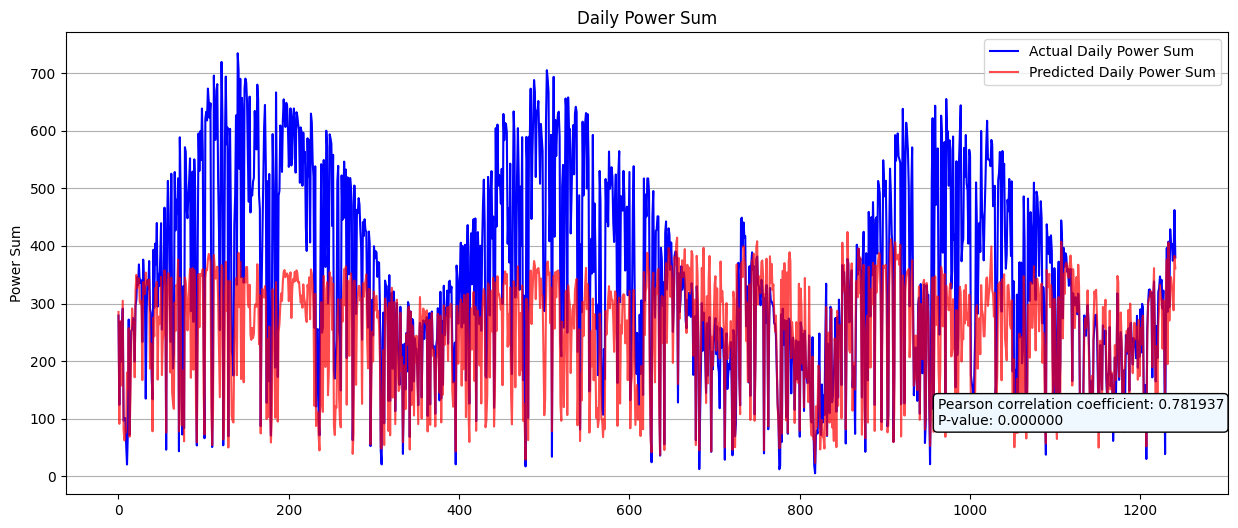

	Completed lgb model.
	Training and Predicting using xgb model...
mae : 16.14747352310686
RMSE : 23.158618532071003
Normalized RMSE : 0.22027325044994892
Error Percentage : 85.01143229227154


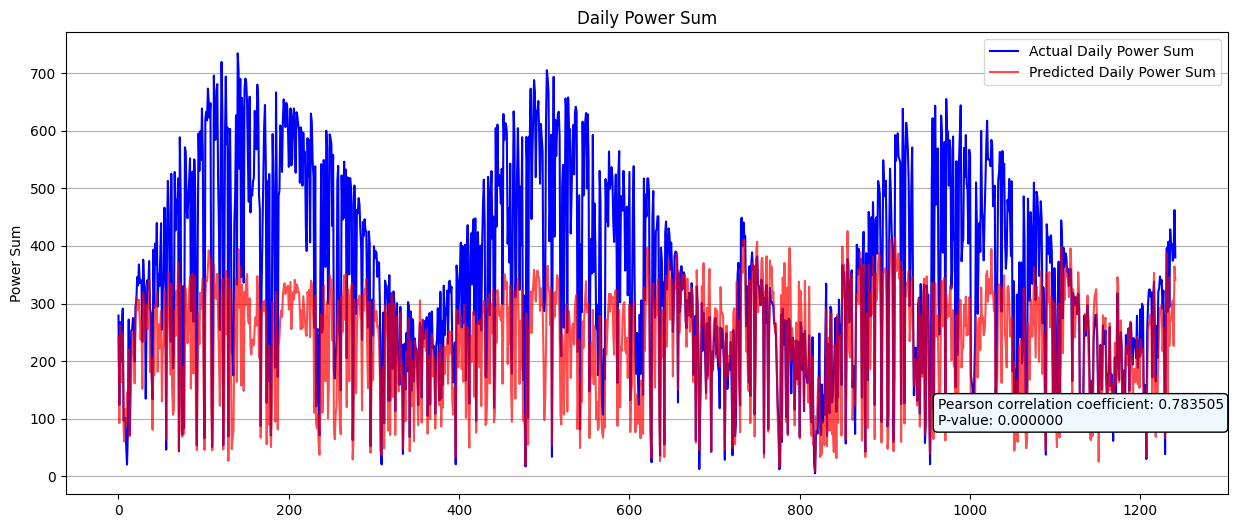

	Completed xgb model.
	Training and Predicting using ext model...


KeyboardInterrupt: 

In [44]:
#165.영암, 112.인천, 140.군산, 133.대전, 288.밀양, 239.세종, 119.수원, 260.장흥, 232.천안])
main(test_nums=[140.], model_choices=['lgb', 'xgb', 'ext', 'rf', 'ngb'])